In [1]:
import math
import torch
import gpytorch
import numpy
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, AdditiveGridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

gpytorch.functions.use_toeplitz = False
%matplotlib inline


Bad key "hatch.linewidth" on line 54 in
/home/gpleiss/.dotfiles/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
n = 100
train_x = torch.zeros(pow(n, 2), 2)
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n-1)
        train_x[i * n + j][1] = float(j) / (n-1)
train_x = Variable(train_x).cuda()
train_y = Variable((torch.sin(train_x.data[:, 0]) + torch.cos(train_x.data[:, 1])) * (2 * math.pi)).cuda()

In [3]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.base_covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.covar_module = AdditiveGridInterpolationKernel(self.base_covar_module, grid_size=400,
                                                            grid_bounds=[(0, 1)], n_components=2)
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)

likelihood = GaussianLikelihood().cuda()
model = GPRegressionModel(train_x.data, train_y.data, likelihood).cuda()

In [4]:
# Optimize the model
model.train()
likelihood.train()

optimizer = optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)
optimizer.n_iter = 0
for i in range(20):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -model.marginal_log_likelihood(likelihood, output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/20 - Loss: %.3f' % (i + 1, loss.data[0]))
    optimizer.step()

Iter 1/20 - Loss: 0.925
Iter 2/20 - Loss: 0.826
Iter 3/20 - Loss: 0.726
Iter 4/20 - Loss: 0.626
Iter 5/20 - Loss: 0.527
Iter 6/20 - Loss: 0.427
Iter 7/20 - Loss: 0.327
Iter 8/20 - Loss: 0.230
Iter 9/20 - Loss: 0.130
Iter 10/20 - Loss: 0.032
Iter 11/20 - Loss: -0.066
Iter 12/20 - Loss: -0.164
Iter 13/20 - Loss: -0.262
Iter 14/20 - Loss: -0.361
Iter 15/20 - Loss: -0.459
Iter 16/20 - Loss: -0.556
Iter 17/20 - Loss: -0.652
Iter 18/20 - Loss: -0.749
Iter 19/20 - Loss: -0.845
Iter 20/20 - Loss: -0.940


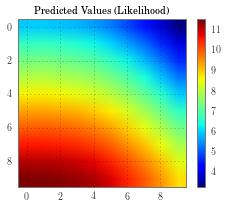

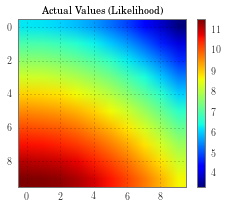

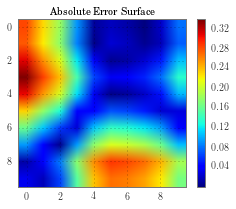

In [6]:
model.eval()
likelihood.eval()

n = 10
test_x = Variable(torch.zeros(int(pow(n, 2)), 2)).cuda()
for i in range(n):
    for j in range(n):
        test_x.data[i * n + j][0] = float(i) / (n-1)
        test_x.data[i * n + j][1] = float(j) / (n-1)

observed_pred = likelihood(model(test_x))
pred_labels = observed_pred.mean().view(n, n).data.cpu().numpy()

test_y_actual = ((torch.sin(test_x.data[:, 0]) + torch.cos(test_x.data[:, 1])) * (2 * math.pi))
test_y_actual = test_y_actual.cpu().numpy().reshape(n, n)
delta_y = numpy.absolute(pred_labels - test_y_actual)

def ax_plot(f, ax, y_labels, title):
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Likelihood)')

f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')

f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax3, delta_y, 'Absolute Error Surface')